In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Building a classifier to predict human neuron subclasses from ephys features

Use electrophysiology features from single neuron recordings to predict cell-type as defined by transcriptomic profile

This model has the ability to predict a cell’s type without spending the time and money to send the sample through RNA-seq, potentially saving thousands of dollars.

In [2]:
#read in data from 2 sources, culture data and acute (standard) data
culture_data = pd.read_csv('culture_ephys_200415.csv')
data = pd.read_csv('human_200428.csv')
data1 = pd.concat([culture_data, data])

#feature engineering
data1['fast_ahp']= data1['threshold_v_short_square'] - data1['fast_trough_v_short_square']
data1 = data1[data1['Norm_Marker_Sum.0.4_label']== True]

#restrict data to relevant subclasses
data1 = data1[data1['subclass_label'].isin(['LAMP5/PAX6/Other','PVALB', 'SST', 'VIP'])]

#ephys features important for classification
features = ['upstroke_downstroke_ratio_long_square', 'tau',
       'ri', 'sag',
       'threshold_i_short_square', 'fast_ahp', 'latency', 'adaptation',
       'fast_trough_v_long_square', 'fast_trough_v_ramp', 'threshold_i_ramp',
       'threshold_t_ramp', 'avg_isi', 'threshold_v_ramp',
       'threshold_v_long_square', 'peak_v_long_square', 'trough_v_ramp']



data1 = data1[['subclass_label'] + features]
data1 = data1.dropna()


data1

C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\envs\umap3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,subclass_label,upstroke_downstroke_ratio_long_square,tau,ri,sag,threshold_i_short_square,fast_ahp,latency,adaptation,fast_trough_v_long_square,fast_trough_v_ramp,threshold_i_ramp,threshold_t_ramp,avg_isi,threshold_v_ramp,threshold_v_long_square,peak_v_long_square,trough_v_ramp
0,LAMP5/PAX6/Other,3.206679,25.615145,292.032540,0.064919,47.125,9.371254,0.02742,0.033713,-50.356251,-50.872913,26.750000,1.568467,57.770000,-39.893749,-39.543751,40.787498,-56.943752
1,LAMP5/PAX6/Other,3.842133,21.026884,371.867418,0.005976,100.000,9.593750,0.00790,0.017153,-46.075001,-46.931248,9.958333,0.896427,46.314286,-36.977081,-37.968750,35.718750,-51.666668
3,LAMP5/PAX6/Other,2.839593,16.935895,252.468705,0.034874,290.000,4.043751,0.02126,0.053285,-43.568748,-43.500000,31.666666,1.750333,41.431818,-40.341663,-40.593750,27.900000,-49.472916
6,LAMP5/PAX6/Other,3.333950,57.667624,841.105652,0.147336,270.000,15.399998,0.01846,0.030522,-54.906250,-55.156250,10.000000,0.897430,51.301053,-39.546875,-39.000000,43.531250,-59.546875
7,LAMP5/PAX6/Other,2.992211,27.438774,260.874897,0.049230,350.000,13.098747,0.03446,0.061671,-47.131248,-48.154163,28.208334,1.625767,64.412857,-35.504166,-33.518749,45.293751,-49.529163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,LAMP5/PAX6/Other,3.071436,20.362734,222.479180,0.201117,510.000,2.837498,0.03456,0.054808,-50.174999,-49.585419,30.041666,1.700553,56.597500,-43.622913,-45.293751,28.631250,-57.689579
2858,LAMP5/PAX6/Other,2.954937,39.560815,206.406251,0.018172,780.000,16.812500,0.05788,0.105285,-53.125000,-55.187500,133.375000,5.830480,159.800000,-40.187500,-38.812500,42.843750,-55.375000
2975,VIP,1.729731,25.836526,527.551397,0.203297,250.000,20.662498,0.16172,0.013709,-55.968750,-53.406250,82.062500,3.780120,42.785882,-29.843750,-34.937500,36.031250,-53.593750
3124,PVALB,2.117482,11.421373,135.468766,0.092579,185.375,20.378574,0.02506,0.024105,-62.387501,-61.852081,90.083336,4.101653,56.603529,-34.472916,-38.287498,37.662498,-62.045834


In [3]:
data1.subclass_label.value_counts()

LAMP5/PAX6/Other    333
PVALB               245
VIP                 129
SST                 119
Name: subclass_label, dtype: int64

In [4]:
#need to upsample the minority classes due to class imbalance of targets

df_minority = data1[data1['subclass_label'].isin(['SST','VIP'])]
df_majority = data1[data1['subclass_label'] .isin(['PVALB','LAMP5/PAX6/Other'])]
 
#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=600,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.subclass_label.value_counts()

LAMP5/PAX6/Other    333
VIP                 314
SST                 286
PVALB               245
Name: subclass_label, dtype: int64

In [5]:
#create targets

target = {'LAMP5/PAX6/Other': 0,'PVALB':1, 'SST':2, 'VIP':3}
targets = np.array(df_upsampled['subclass_label'].map(target))
df_upsampled['subclass'] = targets

In [6]:
data_targets = df_upsampled.drop(['subclass_label'], axis =1)
unscaled_inputs = data_targets.iloc[:,:-1]

#scale inputs to normalize them into a range 0-1
subclass_scaler = StandardScaler()
subclass_scaler.fit(unscaled_inputs)
scaled_inputs = subclass_scaler.transform(unscaled_inputs)

#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, train_size = 0.8, random_state = 20)

#initiate and fit random forest classifier
classifier = RandomForestClassifier(n_estimators=60, random_state= 0, class_weight = {0:1,1:1,2:2,3:1})
classifier.fit(x_train, y_train)
classifier.score(x_train, y_train)


0.9989384288747346

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

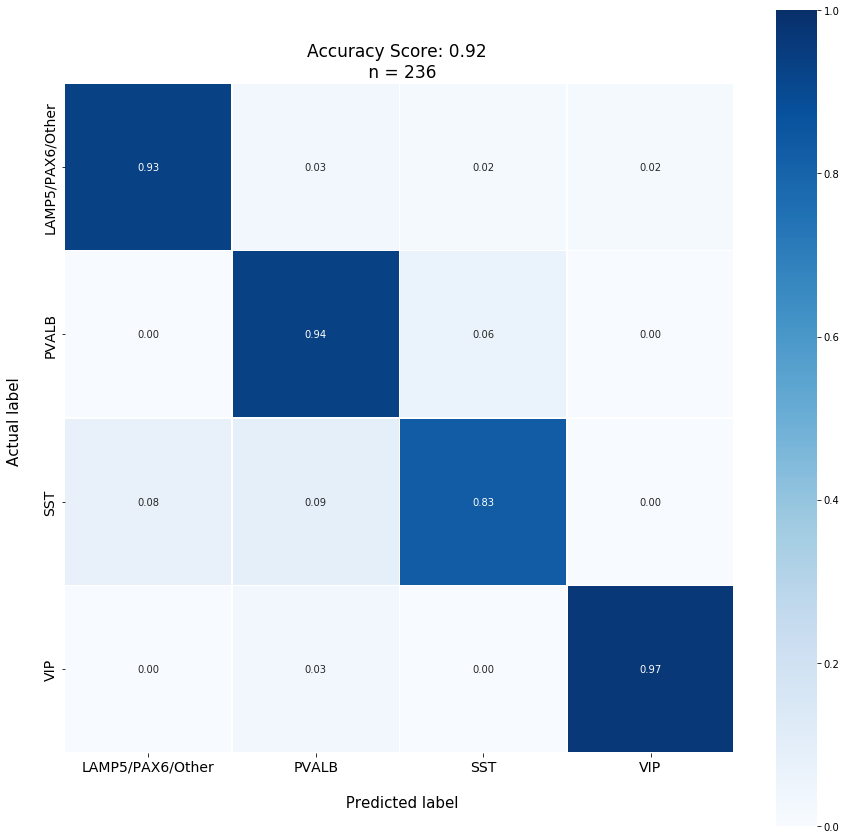

In [7]:
#calculate accuracy score
score = classifier.score(x_test,y_test)

#use model to make predictions on test data
predictions = classifier.predict(x_test)

#plot confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues',
            yticklabels = ['LAMP5/PAX6/Other','PVALB','SST', 'VIP'],
            xticklabels = ['LAMP5/PAX6/Other','PVALB','SST','VIP'], vmax=1)
plt.ylabel('Actual label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'Accuracy Score: {:.2f} \n n = {}'.format(score, predictions.size)
plt.title(all_sample_title, size = 17)
plt.xticks(size=14)
plt.yticks(size=14)
#plt.savefig('human_confusion_matrix_200511.png', dpi =300)

In [8]:
#check which features are being used to make model predictions and their importances

feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = unscaled_inputs.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
upstroke_downstroke_ratio_long_square,0.110261
tau,0.096264
sag,0.082037
fast_ahp,0.066821
threshold_i_short_square,0.061789
adaptation,0.061441
latency,0.057766
ri,0.057747
fast_trough_v_long_square,0.054527
threshold_t_ramp,0.048663


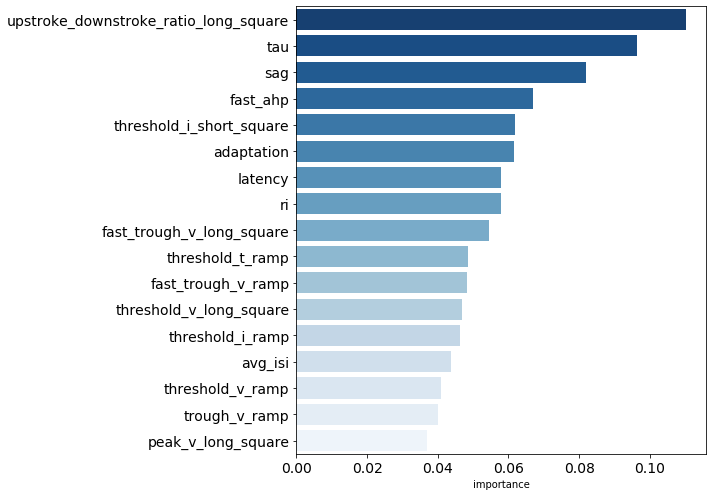

In [9]:
plt.figure(figsize=(10,7))
sns.barplot(x= feature_importances.importance, y=feature_importances.index, palette = 'Blues_r')
plt.xticks(size= 14)
plt.yticks(size = 14)
plt.tight_layout()
#plt.savefig('feature_importance_200504.png')

## save the model

In [10]:
import pickle

In [11]:
with open('human_subclass_model', 'wb') as file:
    pickle.dump(classifier, file)
    
with open('human_subclass_scaler', 'wb') as file:
    pickle.dump(subclass_scaler, file)

In [12]:
class Subclass_model():
    
    def __init__(self, model_file, scaler_file):
        #read model and scaler files which were saved
        with open('human_subclass_model', 'rb') as model_file, open('human_subclass_scaler', 'rb') as scaler_file:
            self.classifier = pickle.load(model_file)
            self.scaler = pickle.load(scaler_file)
            self.data = None
            
    def load_and_clean_data(self, data_file):
        #import data
        df = pd.read_csv(data_file)

        #data clean
        df['fast_ahp']= df['threshold_v_short_square'] - df['fast_trough_v_short_square']
    
        features = ['upstroke_downstroke_ratio_long_square', 'tau',
               'ri', 'sag',
               'threshold_i_short_square', 'fast_ahp', 'latency', 'adaptation',
               'fast_trough_v_long_square', 'fast_trough_v_ramp', 'threshold_i_ramp',
               'threshold_t_ramp', 'avg_isi', 'threshold_v_ramp',
               'threshold_v_long_square', 'peak_v_long_square', 'trough_v_ramp'] 
        
        
        df2 = df[features + ['specimen_id', 'name']]
        df = df[features]
        df = df.dropna()
        df2 = df2.dropna()
        self.preprocessed_data = df2.copy()
        
        self.data = self.scaler.transform(df)

        
    def predicted_probability(self):
        if (self.data is not None):
            pred = self.classifier.predict_proba(self.data)
            return pred
        
    def predicted_output_category(self):
        if (self.data is not None):
            pred_outputs = self.classifier.predict(self.data)
            return pred_outputs
            
    def predicted_outputs(self):
        targets = {0:'Lamp5/Pax6/Other', 1: 'Pvalb', 2:'Sst', 3:'Vip', 4:'Excitatory'}
        if (self.data is not None):
            self.preprocessed_data['prediction'] = self.classifier.predict(self.data)
            #return self.preprocessed_data[['specimen_id','name','qualitative call','prediction']]
            self.preprocessed_data['predicted_subclass'] = self.preprocessed_data['prediction'].map(targets)
        
            #return self.preprocessed_data[['specimen_id','name','prediction','predicted_subclass']]
            return self.preprocessed_data[['specimen_id','prediction','predicted_subclass']]

## Run model on new data

In [13]:
model_file = pickle.load(open('human_subclass_model', 'rb'))
scaler_file = pickle.load(open('human_subclass_scaler', 'rb'))

In [14]:
test = Subclass_model(model_file, scaler_file)

In [15]:
test.load_and_clean_data('ME_200501.csv')

In [16]:
test.predicted_outputs()

,specimen_id,prediction,predicted_subclass
2,485537619.0,0,Lamp5/Pax6/Other
3,486748229.0,0,Lamp5/Pax6/Other
5,486749782.0,0,Lamp5/Pax6/Other
6,486940963.0,0,Lamp5/Pax6/Other
7,488385201.0,0,Lamp5/Pax6/Other
...,...,...,...
890,642981071.0,0,Lamp5/Pax6/Other
891,643572206.0,1,Pvalb
894,643584386.0,1,Pvalb
897,643601251.0,0,Lamp5/Pax6/Other


In [17]:
test.predicted_probability()

array([[0.85      , 0.        , 0.05      , 0.1       ],
       [0.68333333, 0.08333333, 0.13333333, 0.1       ],
       [0.51666667, 0.26666667, 0.1       , 0.11666667],
       ...,
       [0.03333333, 0.68055556, 0.20277778, 0.08333333],
       [0.73333333, 0.11666667, 0.06666667, 0.08333333],
       [0.3       , 0.1       , 0.21666667, 0.38333333]])